<a href="https://colab.research.google.com/github/bamacgabhann/PTSA/blob/main/PTSA.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PTSA - Public Transit Service Areas - is a Python package to generate service area polygons around public transit locations (e.g. bus stops, train stations) using several different methods.

This Notebook uses PTSA to generate service areas for bus stops in Limerick and Sligo (Ireland), using several different methods, and evaluate the results.

If you are using Google Colab to run this Notebook, you can run the following cell to connect a Google Drive.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

If you are using Google Colab to run this Notebook, you will need to run the following cell to install missing packages:

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install osmnx
#    !pip install movingpandas hvplot cartopy geoviews

Import dependencies

In [1]:
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

#from shapely.geometry import Point, LineString, Polygon, box

#import pandas as pd
#import movingpandas as mpd


#import hvplot.pandas

#from datetime import datetime, timedelta
#from holoviews import opts

#import warnings
#warnings.filterwarnings("ignore")

#plot_defaults = {"linewidth": 5, "capstyle": "round", "figsize": (10, 6), "legend": True}

Import GeoPackage files defining the area of interest, and the public transit points

In [2]:
area = gpd.read_file('https://github.com/bamacgabhann/PTSA/raw/refs/heads/main/sample_data/sligo_area.gpkg', layer='sligo_area')
area_10m_buffer = gpd.read_file('https://github.com/bamacgabhann/PTSA/raw/refs/heads/main/sample_data/sligo_area.gpkg', layer='sligo_area_10m_buffer')
service_points = gpd.read_file('https://github.com/bamacgabhann/PTSA/raw/refs/heads/main/sample_data/sligo_bus_stops.gpkg')

Use OSMNX to import roads and footways from Open Street Map for the area of interest:

In [3]:
# Extract a polygon from the geopackage, converting to EPSG:4326 for Open Street Map download
area_polygon = area_10m_buffer.to_crs(4326).geometry[0]

# download the national, secondary, and local roads from OpenStreetMap in the area, converting to EPSG:2157 because a projected CRS is required to generate network, cropping them to the map area
area_roads = ox.features_from_polygon(area_polygon, tags={'highway': ['trunk','trunk_link','primary','primary_link','secondary','secondary_link','tertiary','unclassified','residential','service', 'tertiary_link','pedestrian','footway', 'track', 'path', 'steps']})
area_roads = area_roads[area_roads.geom_type == 'LineString'].to_crs(2157).overlay(area_10m_buffer, how='intersection')

N_list = ['trunk','trunk_link','primary','primary_link']
R_list = ['secondary','secondary_link']
L_list = ['tertiary','unclassified','residential','service', 'tertiary_link']
P_list = ['pedestrian','footway' 'track', 'path', 'steps']

N_roads = area_roads[area_roads['highway'].isin(N_list)]
R_roads = area_roads[area_roads['highway'].isin(R_list)]
L_roads = area_roads[area_roads['highway'].isin(L_list)]
P_roads = area_roads[area_roads['highway'].isin(P_list)]

Use OSMNX to get buildings for the area

In [10]:
# download the buildings
area_buildings = ox.features_from_polygon(area_polygon, tags = {"building": True})
area_buildings = area_buildings[area_buildings.geom_type == 'Polygon'].to_crs(2157).overlay(area, how='intersection')

**Creating Service Areas**

blah

metric


In [6]:
import warnings
import geopandas as gpd

class CRSWarning(UserWarning, ValueError):
    pass

class distanceWarning(UserWarning, ValueError):
    pass

class unitsWarning(UserWarning, ValueError):
    pass

class Transit_System:
    def __init__(
        self,
        network,
        service_points,
        crs=None,
        service_distance=None,
    ):
        """
        
        """  

        if not isinstance(network, gpd.GeoDataFrame):
            raise ValueError(
                "The input network must be a GeoDataFrame"
            )

        if not isinstance(service_points, gpd.GeoDataFrame):
            raise ValueError(
                "The input service points must be a GeoDataFrame"
            )
        
        

        if crs is not None:
            self.crs = crs

        else:
            if network.crs.is_geographic == True:
                
                if service_points.crs.is_geographic == True:
                    raise ValueError(
                        "Service area generation requires a projected CRS."
                        "Please declare or convert network and service points"
                        "to a projected CRS."
                        )
                else:
                    self.crs = service_points.crs
                    warnings.warn(
                        "Using service points CRS",
                        category=CRSWarning,
                    )

            else:
                self.crs = network.crs
                warnings.warn(
                    "Using network CRS",
                    category=CRSWarning,
                )

        self.network = network[~network.index.duplicated(keep="first")].to_crs(self.crs)


#        res = pd.concat([gdf1, gdf2])
        
        self.service_points = service_points[~service_points.index.duplicated(keep="first")].to_crs(self.crs)
        self.crs_units = self.crs.axis_info[0].unit_name
        if service_distance is None:
            self.service_distance = 400        
            if self.crs_units != 'metre':
                warnings.warn(
                    "CRS is non-metric but service area generation uses metric."
                    "Please convert transit system to a metric CRS or declare"
                    "a non-metric service distance",
                    category=unitsWarning,
                )




    def to_crs(self, new_crs):
        """
        Returns the transit system reprojected to the target CRS.

        Parameters
        ----------
        crs : pyproj.CRS
            Target coordinate reference system

        Returns
        -------
        Transit system

        Examples
        --------
        Reproject a transit system to EPSG:4088

        >>> from pyproj import CRS
        >>> reprojected = trajectory.to_crs(CRS(4088))
        """
        copied = Transit_system(network=self.network, service_points=self.service_points, new_crs=crs)
        return copied

    def circle_service_areas(self, points=None, distance=None):
        if points is None:
            points = self.service_points
        if distance is None:
            distance = self.service_distance
        return points.buffer(distance)
    

In [7]:
sligo = Transit_System(area_roads, service_points)
sligo

/tmp/ipykernel_11636/1708110515.py:58: CRSWarning: Using network CRS
  warnings.warn(


In [8]:
sligo_circles = sligo.circle_service_areas()

**Might be needed**

Extra lines between bus stops and closest roads

In [9]:
closest_roads = gpd.sjoin_nearest(service_points, area_roads, how='inner', max_distance=50).merge(area_roads, left_on="index_right", right_index=True)
#closest_roads.geometry_y
lines_to_stops = closest_roads['geometry_x'].shortest_line(closest_roads['geometry_y'])
lines_to_stops.to_file("lines_to_stops.gpkg")

**try buildings tess**

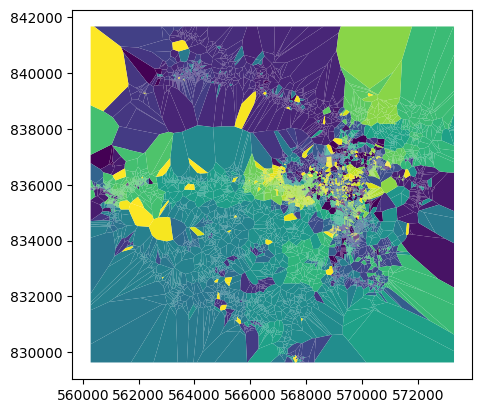

In [19]:
#import momepy
# create a limit for tessellation (join all polygons and buffer that)
limit = area.union_all()

area_buildings['unique_id'] = area_buildings.index

# create tessellation. I am specifying max segment distance and shrink to 500 meters. shrink is needed as the polygons are adjacent
btess = momepy.morphological_tessellation(area_buildings)

# get the resulting GeoDataFrame
#result = btess.tessellation

# plot
ax = btess.plot(cmap="viridis")
#bretagne.plot(ax=ax, color="white", alpha=.5, linewidth=1, edgecolor="black")

In [20]:
btess.to_file("btess.gpkg")

In [15]:
area_buildings

,amenity,building,denomination,historic,name,natural,note,religion,website,wikidata,...,ED_OFFICIAL,ED_ENGLISH,ED_GAEILGE,ED_ID_STR,ED_PART_COUNT,COUNTY_CODE,COUNTY_ENGLISH,COUNTY_GAEILGE,CSO_LEA,geometry
0,NaN,public,NaN,NaN,Government Offices,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((569790.964 835482.052, 569752.566 83..."
1,NaN,school,NaN,NaN,Summerhill College,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((568738.752 835363.179, 568746.402 83..."
2,NaN,office,NaN,NaN,Social Welfare Services Offices,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((569005.162 835081.383, 568983.758 83..."
3,NaN,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((569664.994 835776.563, 569665.137 83..."
4,NaN,school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((569607.019 836995.146, 569614.462 83..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15287,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((568866.846 835991.476, 568866.742 83..."
15288,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((562783.014 836392.282, 562779.651 83..."
15289,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((562110.292 836248.442, 562113.044 83..."
15290,NaN,ruins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,SLIGO NORTH,SLIGEACH THUAIDH,207081,1,31,SLIGO,Sligeach,SLIGO-STRANDHILL,"POLYGON ((561280.328 839394.804, 561294.407 83..."


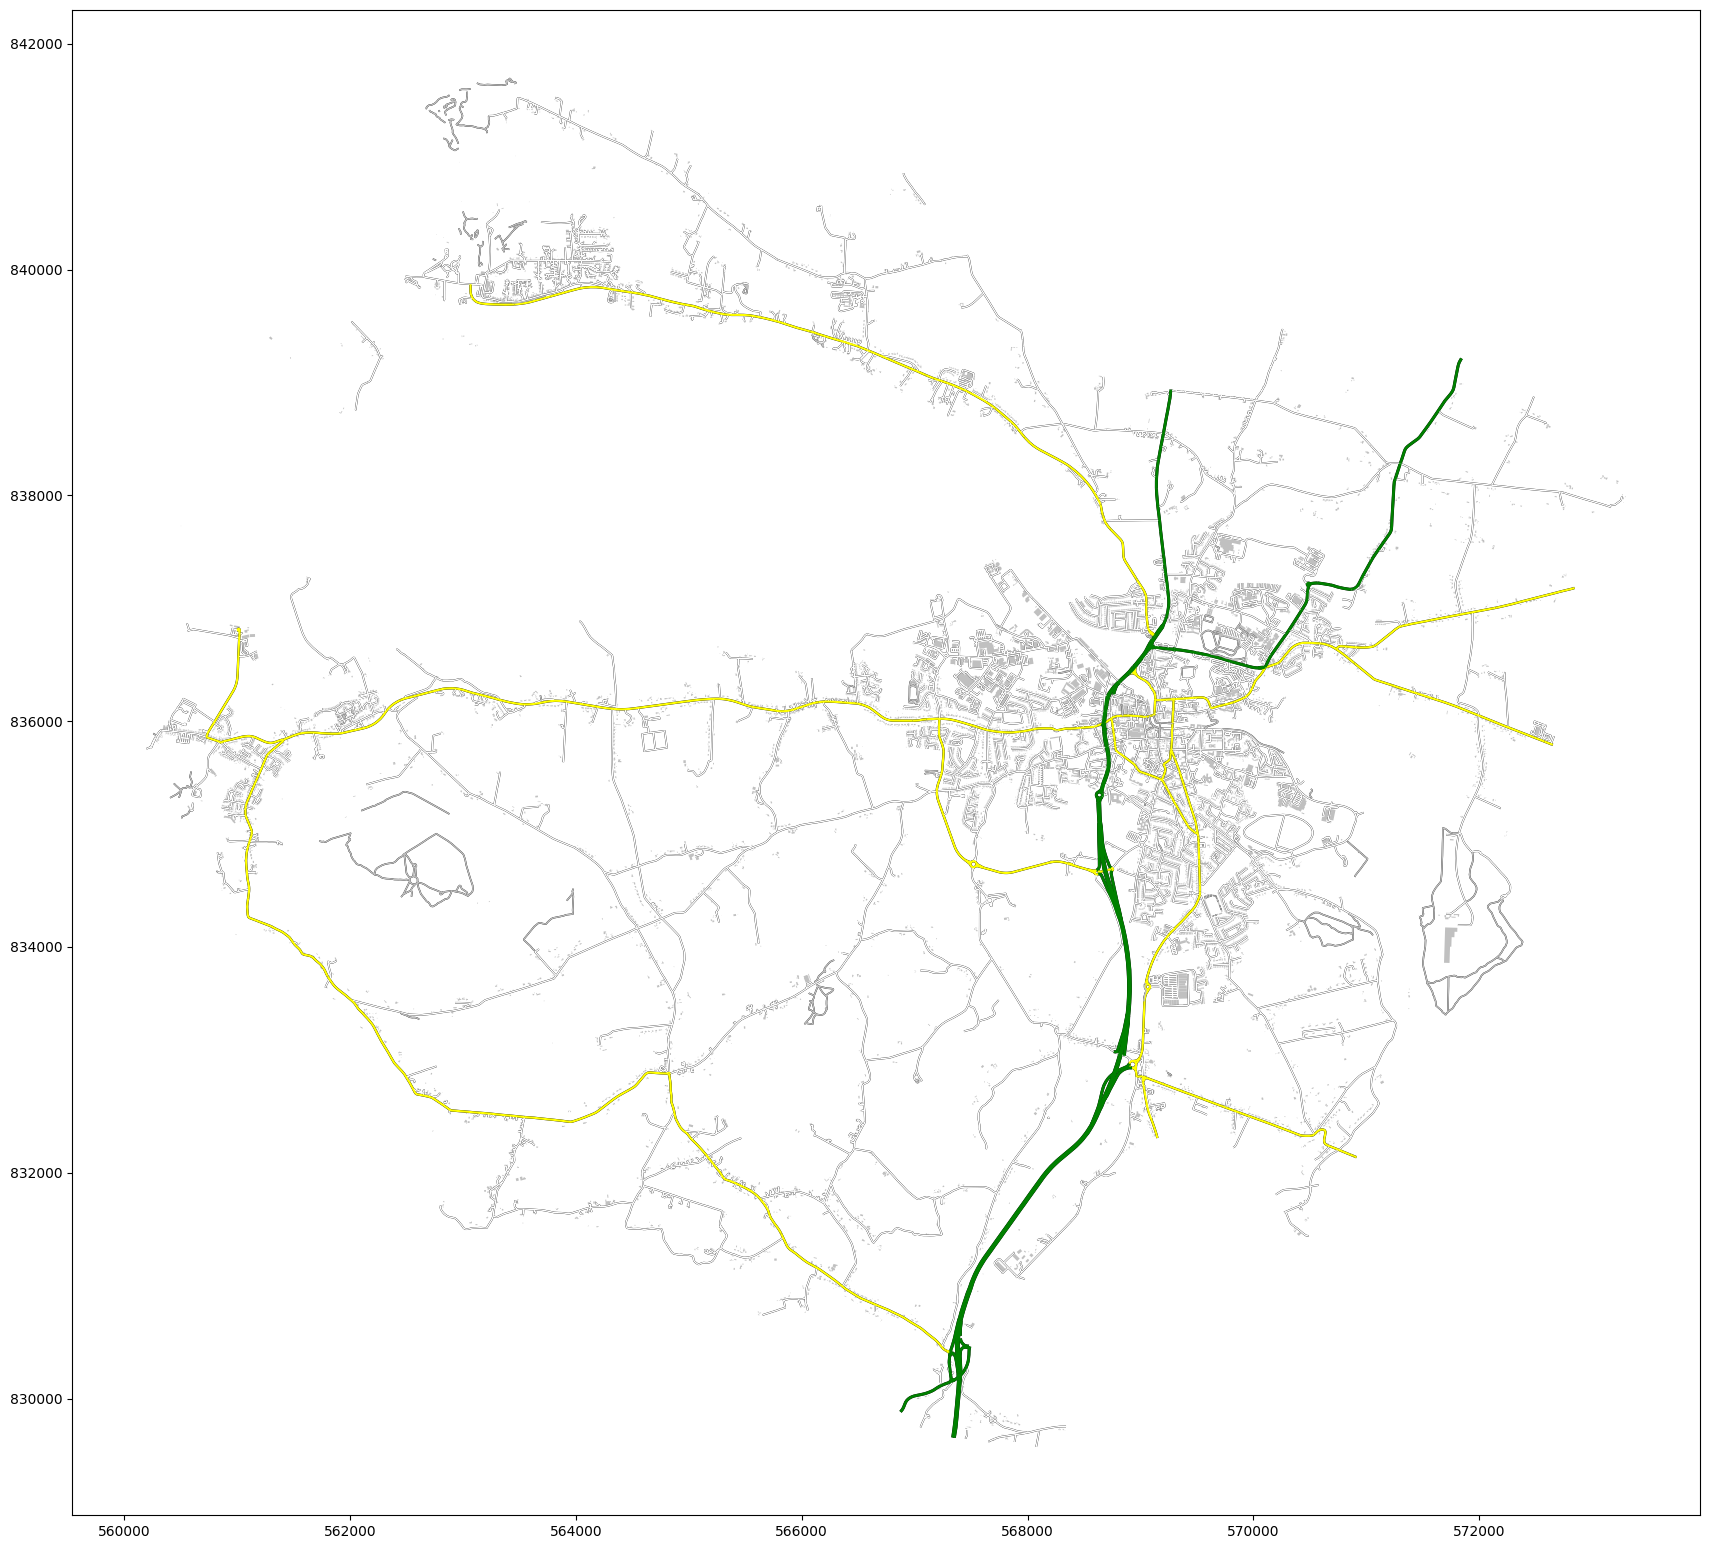

In [11]:
# plot
fig, ax = plt.subplots(figsize=(21, 21))

# plot all roads with a thicker black line which will show as edges,
# and a main line coloured by category
L_roads.plot(ax=ax, color='black', linewidth=1.2)
R_roads.plot(ax=ax, color='black', linewidth=1.7)
N_roads.plot(ax=ax, color='black', linewidth=2.2)
P_roads.plot(ax=ax, color='black', linewidth=1.1)
L_roads.plot(ax=ax, color='white', linewidth=1)
R_roads.plot(ax=ax, color='yellow', linewidth=1.5)
N_roads.plot(ax=ax, color='green', linewidth=2)
P_roads.plot(ax=ax, color='silver', linewidth=1)

# plot the buildings
area_buildings.plot(ax=ax, color='silver')

#sligo_circles.boundary.plot(ax=ax)

plt.show()